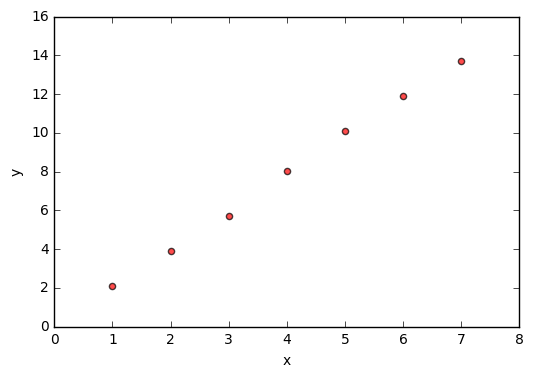

In [34]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

x = np.array([1, 2, 3, 4, 5, 6, 7]).astype(np.float32)
y = np.array([2.1, 3.9, 5.7, 8.01, 10.1, 11.9, 13.7]).astype(np.float32)


plt.scatter(x, y, alpha=.7,c='r')
#plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')



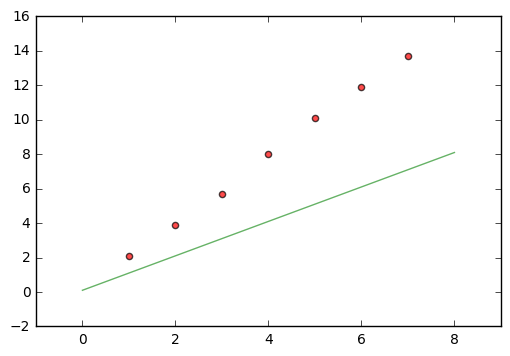

In [35]:
a = 1
b = 0.1

line_x_range = (0, 8)

plt.scatter(x, y, alpha=.7,c='r')

plt.plot(line_x_range, [a*xx+b for xx in line_x_range], "g", alpha=0.6)
plt.show()

In [36]:
for i in range(100):
    c = random.randrange(len(x))
    yy = a*x[c]+b
    err = y[c] - yy
    print x[c], y[c], 




3.0 5.7 2.0 3.9 3.0 5.7 1.0 2.1 7.0 13.7 3.0 5.7 4.0 8.01 7.0 13.7 6.0 11.9 4.0 8.01 7.0 13.7 2.0 3.9 7.0 13.7 5.0 10.1 6.0 11.9 1.0 2.1 1.0 2.1 7.0 13.7 3.0 5.7 3.0 5.7 4.0 8.01 6.0 11.9 2.0 3.9 4.0 8.01 6.0 11.9 6.0 11.9 3.0 5.7 6.0 11.9 6.0 11.9 2.0 3.9 6.0 11.9 5.0 10.1 5.0 10.1 6.0 11.9 2.0 3.9 2.0 3.9 1.0 2.1 6.0 11.9 3.0 5.7 5.0 10.1 2.0 3.9 3.0 5.7 1.0 2.1 7.0 13.7 5.0 10.1 6.0 11.9 6.0 11.9 4.0 8.01 5.0 10.1 6.0 11.9 2.0 3.9 2.0 3.9 6.0 11.9 1.0 2.1 7.0 13.7 5.0 10.1 1.0 2.1 1.0 2.1 1.0 2.1 1.0 2.1 7.0 13.7 5.0 10.1 6.0 11.9 5.0 10.1 4.0 8.01 5.0 10.1 6.0 11.9 2.0 3.9 7.0 13.7 6.0 11.9 6.0 11.9 7.0 13.7 6.0 11.9 4.0 8.01 3.0 5.7 2.0 3.9 6.0 11.9 3.0 5.7 4.0 8.01 3.0 5.7 7.0 13.7 3.0 5.7 3.0 5.7 5.0 10.1 1.0 2.1 4.0 8.01 2.0 3.9 6.0 11.9 1.0 2.1 5.0 10.1 5.0 10.1 6.0 11.9 3.0 5.7 7.0 13.7 5.0 10.1 3.0 5.7 6.0 11.9 5.0 10.1 4.0 8.01 5.0 10.1
